## 1 读取数据预处理的文件

In [77]:
import numpy as np
import pandas as pd
from pandas import  DataFrame

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
np.random.seed(7)

df = pd.read_csv(r"./泰迪杯数据01.csv")
df

,日期1,总有功功率（kw）,最高温度,最低温度,白天风力风向,夜晚风力风向,天气1,天气2
0,2018/1/1 00:00:00,244033.7682,22,12,3,3,3.0,3.0
1,2018/1/1 00:15:00,232720.6402,22,12,3,3,3.0,3.0
2,2018/1/1 00:30:00,231685.6891,22,12,3,3,3.0,3.0
3,2018/1/1 00:45:00,227581.3317,22,12,3,3,3.0,3.0
4,2018/1/1 01:00:00,233482.4269,22,12,3,3,3.0,3.0
...,...,...,...,...,...,...,...,...
128631,2021/8/31 22:45:00,202409.1270,32,26,1,1,7.0,6.0
128632,2021/8/31 23:00:00,218576.4635,32,26,1,1,7.0,6.0
128633,2021/8/31 23:15:00,200112.5091,32,26,1,1,7.0,6.0
128634,2021/8/31 23:30:00,199865.5937,32,26,1,1,7.0,6.0


## 数据处理

In [78]:
df.columns
df  = df.rename(columns={'日期1':'date'}) #将日期1改为date

In [79]:
df.isna().sum()

date           0
总有功功率（kw）      0
最高温度           0
最低温度           0
白天风力风向         0
夜晚风力风向         0
天气1          960
天气2          288
dtype: int64

In [80]:
df = df.fillna(method='ffill',axis=0)
df['date'] = pd.to_datetime(df['date'])

In [81]:
#补缺失值
df['总有功功率（kw）'] = df['总有功功率（kw）'].interpolate()
df.index = df['date']

In [82]:
# 行重复删除
df[df.index.duplicated()]
df.loc['2020-09-01 00:00:00']
df = df[~df.index.duplicated()]

## 查看数据

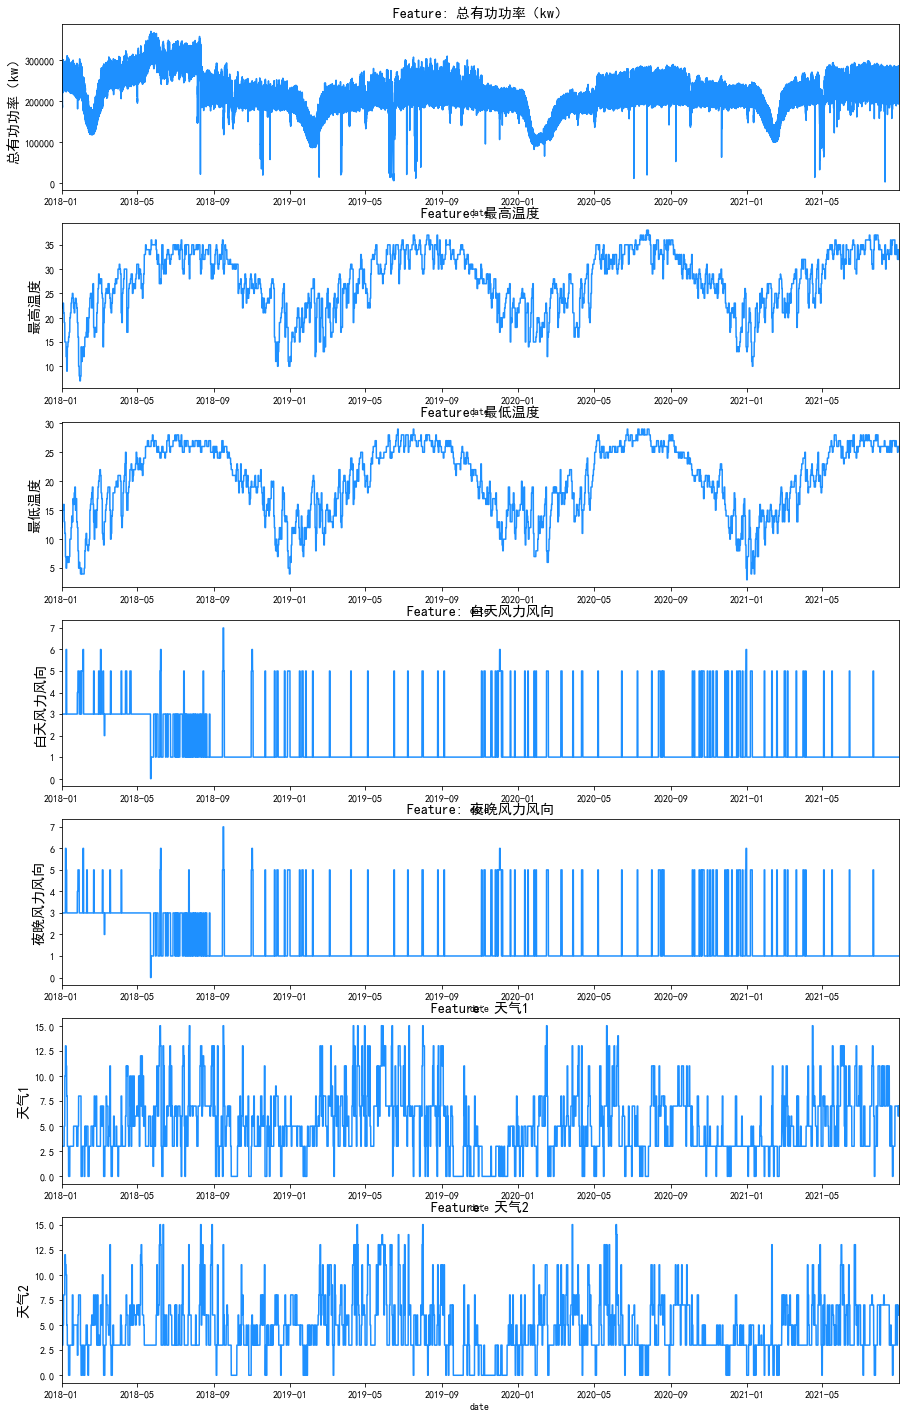

In [83]:
f, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):  #enumerate将组成一个遍历序列
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')  #lineplot方法画图
    ax[i].set_title('Feature: {}'.format(column), fontsize=14) #显示标题
    ax[i].set_ylabel(ylabel=column, fontsize=14) #显示y轴变量

    ax[i].set_xlim([date(2018, 1, 1), date(2021, 8, 31)]) #设置x轴的范围

## 数据平滑与采样

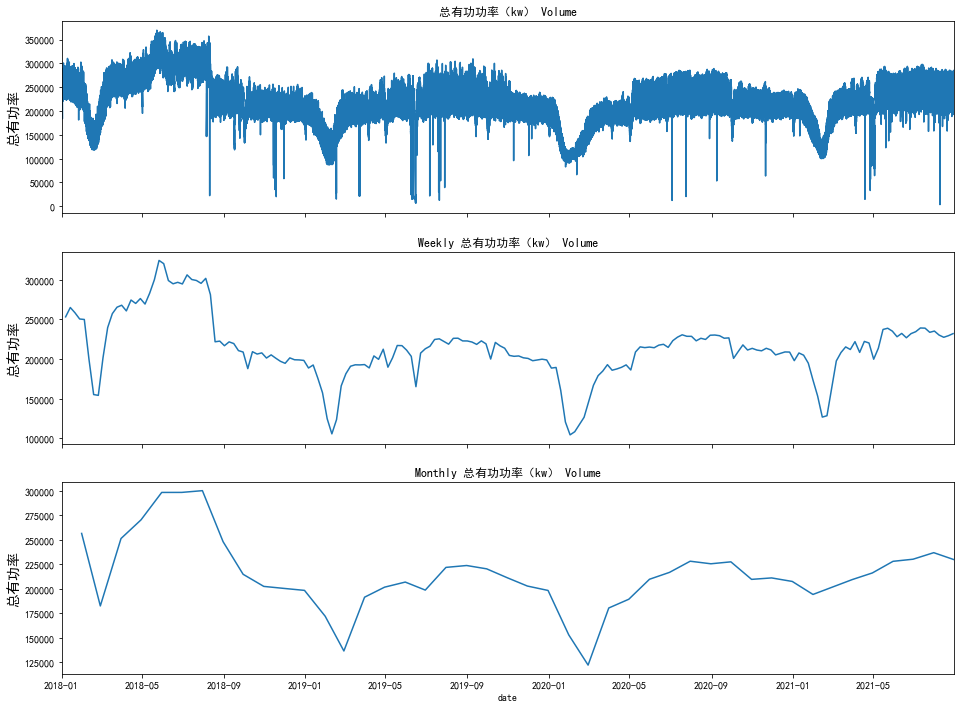

In [84]:
fig, ax = plt.subplots(nrows=3,ncols=1, sharex=True, figsize=(16,12))

sns.lineplot(x=df['date'],y=df['总有功功率（kw）'],ax=ax[0])
ax[0].set_title('总有功功率（kw） Volume')
ax[0].set_ylabel(ylabel='总有功率',fontsize=14)

ts = df['总有功功率（kw）'].resample('W',closed='left').mean()
sns.lineplot(x=df['date'],y=ts,ax=ax[1])
ax[1].set_title('Weekly 总有功功率（kw） Volume')
ax[1].set_ylabel(ylabel='总有功率',fontsize=14)

ts = df['总有功功率（kw）'].resample('M',closed='left').mean()
sns.lineplot(x=df['date'],y=ts,ax=ax[2])
ax[2].set_title('Monthly 总有功功率（kw） Volume')
ax[2].set_ylabel(ylabel='总有功率',fontsize=14)


for i in range(3):
    ax[i].set_xlim([date(2018,1,1),date(2021,8,31)])
    plt.show()

In [85]:
#查看平滑后数据
downsample = df[['date',
                 '总有功功率（kw）', 
                ]].resample('7D', on='date').mean().reset_index(drop=True) #将数据平滑到每个星期

downsample

,总有功功率（kw）
0,254094.368485
1,264490.044881
2,257543.163442
3,249642.665462
4,246145.866215
...,...
187,230609.177496
188,226639.084830
189,230264.816100
190,232199.219353


## 5 平稳性检验

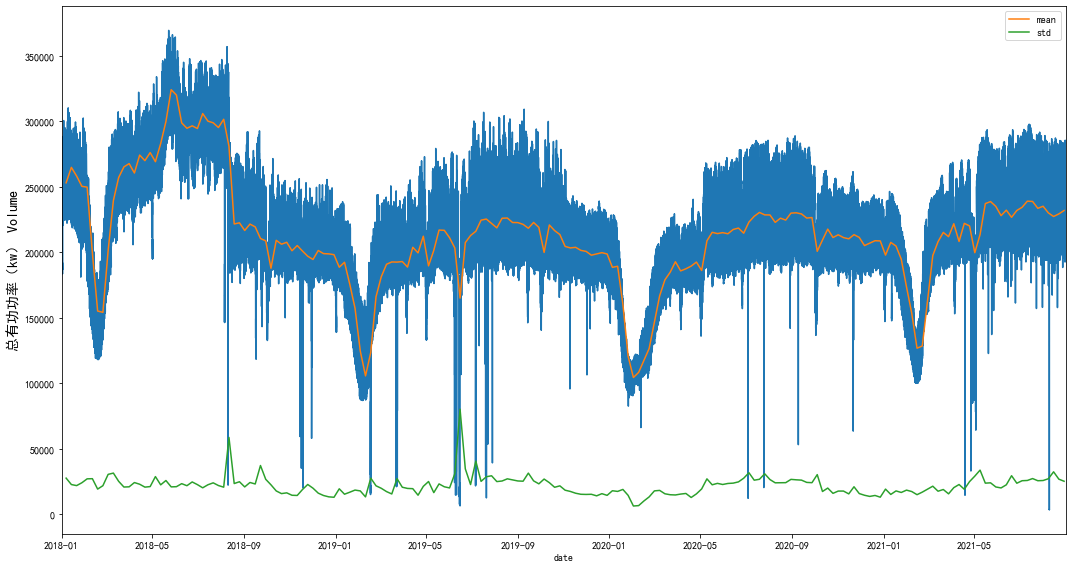

In [86]:
rolling_window = 52
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

ts = df['总有功功率（kw）'].resample('W',closed='left').mean()
ts1 = df['总有功功率（kw）'].resample('W',closed='left').std()
sns.lineplot(x=df['date'],y=df['总有功功率（kw）'],ax=ax)
sns.lineplot(x=df['date'],y=ts,ax=ax,label='mean')
sns.lineplot(x=df['date'],y=ts1,ax=ax,label='std')
ax.set_ylabel(ylabel='总有功功率（kw） Volume', fontsize=14)
ax.set_xlim([date(2018, 1, 1), date(2021, 8, 31)])
plt.tight_layout()
plt.show()

In [87]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['总有功功率（kw）'].values)
result
#p值小于0.05，第一个值比第五个值小，趋势平稳

(-6.674613892094378,
 4.497898806395118e-09,
 72,
 128083,
 {'1%': -3.430401056198406,
  '5%': -2.8615625660943227,
  '10%': -2.566782011132868},
 2641933.054895261)

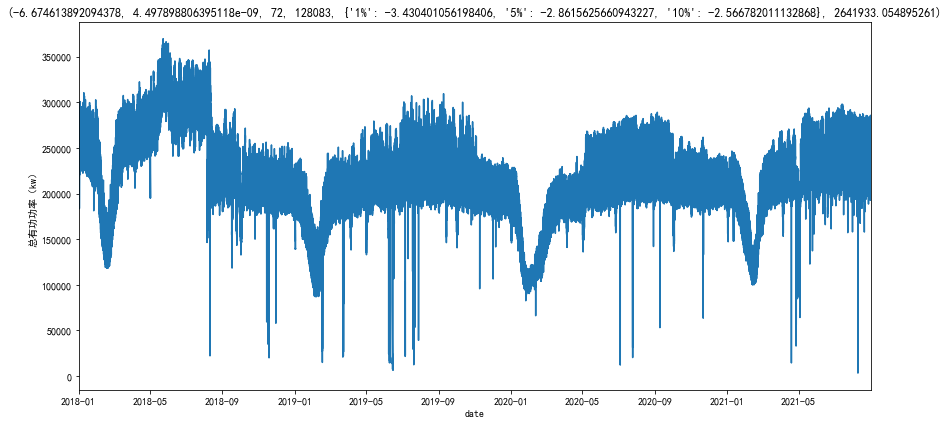

In [88]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

def visualize_adfuller_results(series, title, ax):
    sns.lineplot(x=df['date'],y=series,ax=ax)
    ax.set_title(result)
    ax.set_ylabel(title)
    ax.set_xlim([date(2018, 1, 1), date(2021, 8, 31)])

visualize_adfuller_results(df['总有功功率（kw）'].values, '总有功功率（kw）',ax=ax)
# visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
# visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
# visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
# visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

# f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

## 白噪声检验

In [89]:
from statsmodels.stats.diagnostic import accorr_ljungbox
#返回统计量与p值
print('差分序列的白噪声检验结果为:',accorr_ljungbox(df['date'],lags=1,return_df=True))

ImportError: cannot import name 'accorr_ljungbox' from 'statsmodels.stats.diagnostic' (D:\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py)

In [90]:
#如果不是静态的，我们想使用一个模型，则数据必须转换。将数据转换为平稳序列的两种最常见的方法是：#
#变换：例如对数或平方根，以稳定非恒定方差
#差分：从以前的值中减去当前值

## 6 数据转换

## 对数

<AxesSubplot:xlabel='总有功功率（kw）_log', ylabel='Density'>

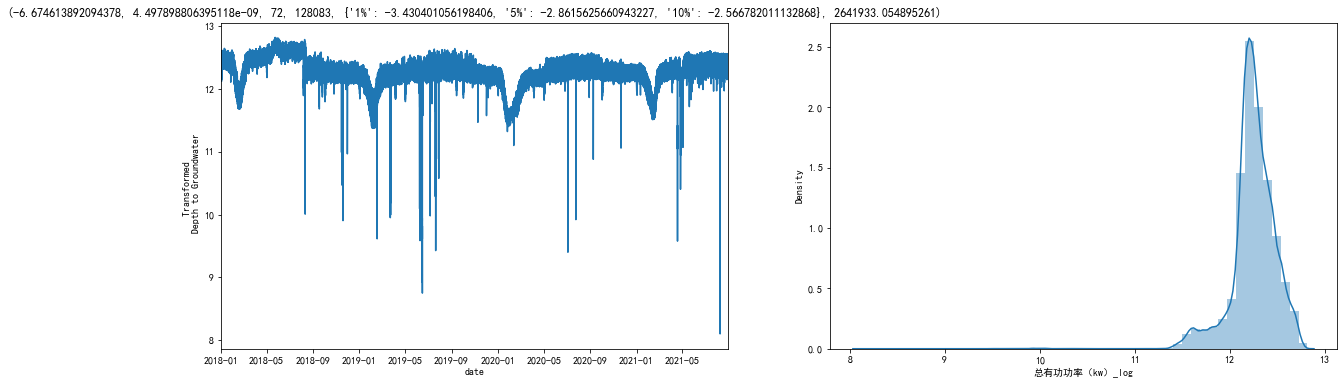

In [91]:
#以e为底的对数
df['总有功功率（kw）_log'] = np.log(df['总有功功率（kw）'])

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['总有功功率（kw）_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['总有功功率（kw）_log'], ax=ax[1]) #直方图和核密度图的结合，查看单个连续型变量的分布

## 一阶差分

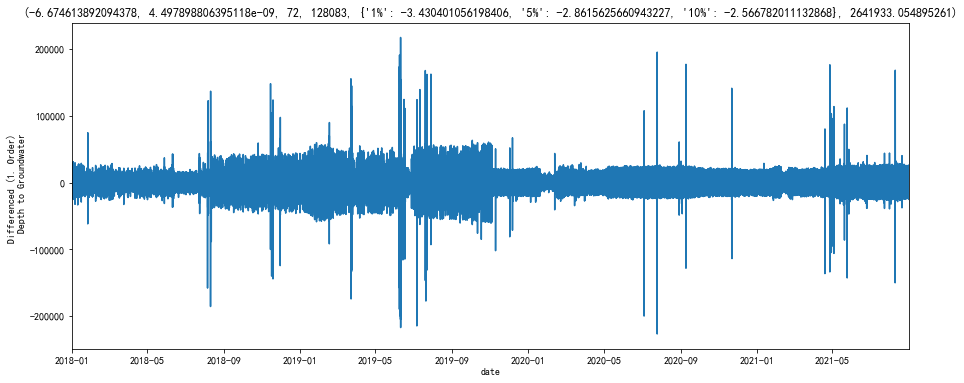

In [92]:
# 一阶差分
ts_diff = np.diff(df['总有功功率（kw）'])  #获取前一个与后一个数的差值
df['总有功功率（kw）_diff_1'] = np.append([0], ts_diff)  #将ts_diff(差值)放进总功率

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['总有功功率（kw）_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

## 异常值处理

In [93]:
from scipy.stats import kstest
#正态检测
u = df['总有功功率（kw）'].mean()
# 计算标准差
std = df['总有功功率（kw）'].std()
# 计算P值
res=kstest(df['总有功功率（kw）'].astype(float),  'norm', (u, std))[1]
print(res)
# 判断p值是否服从正态分布，p<=0.05 则服从正态分布，否则不服从。
if res<=0.05:
    print('该列数据服从正态分布------------')
    print('均值为：%.3f，标准差为：%.3f' % (u, std))
    print('------------------------------')
else:
    print("错误")

#KS检验3σ异常点检测
sum =[]
# 计算均值
u = df['总有功功率（kw）'].mean()
# 计算标准差
std = df['总有功功率（kw）'].std()
# 定义3σ法则识别异常值
# 识别异常值
error = df['总有功功率（kw）'][np.abs(df['总有功功率（kw）'] - u) > 3 * std]
df.loc[error.index,'总有功功率（kw）'] = np.nan
# 剔除异常值，保留正常的数据
data_c = df['总有功功率（kw）'][np.abs(df['总有功功率（kw）'] - u) <= 3 * std]
# 输出异常数据
sum.append(error)
# print(error)

0.0
该列数据服从正态分布------------
均值为：213680.590，标准差为：45331.198
------------------------------


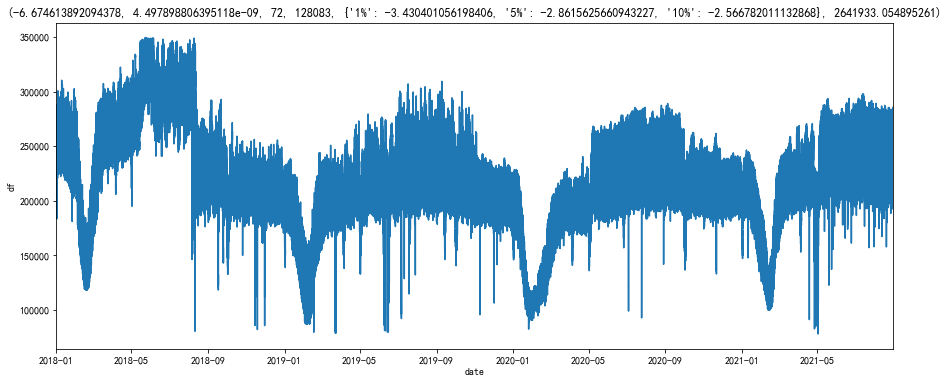

In [94]:
df = df.fillna(method='ffill',axis=0)  #异常处理

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['总有功功率（kw）'],'df' , ax=ax)

In [95]:
from scipy.stats import kstest
#正态检测
u = df['总有功功率（kw）_diff_1'].mean()
# 计算标准差
std = df['总有功功率（kw）_diff_1'].std()
# 计算P值
res=kstest(df['总有功功率（kw）_diff_1'].astype(float),  'norm', (u, std))[1]
print(res)
# 判断p值是否服从正态分布，p<=0.05 则服从正态分布，否则不服从。
if res<=0.05:
    print('该列数据服从正态分布------------')
    print('均值为：%.3f，标准差为：%.3f' % (u, std))
    print('------------------------------')
else:
    print("错误")

#KS检验3σ异常点检测
sum =[]
# 计算均值
u = df['总有功功率（kw）_diff_1'].mean()
# 计算标准差
std = df['总有功功率（kw）_diff_1'].std()
# 定义3σ法则识别异常值
# 识别异常值
error = df['总有功功率（kw）_diff_1'][np.abs(df['总有功功率（kw）_diff_1'] - u) > 3 * std]
df.loc[error.index,'总有功功率（kw）_diff_1'] = np.nan
# 剔除异常值，保留正常的数据
data_c = df['总有功功率（kw）_diff_1'][np.abs(df['总有功功率（kw）_diff_1'] - u) <= 3 * std]
sum.append(error)
# 输出异常数据
# print(error)

0.0
该列数据服从正态分布------------
均值为：-0.355，标准差为：12871.263
------------------------------


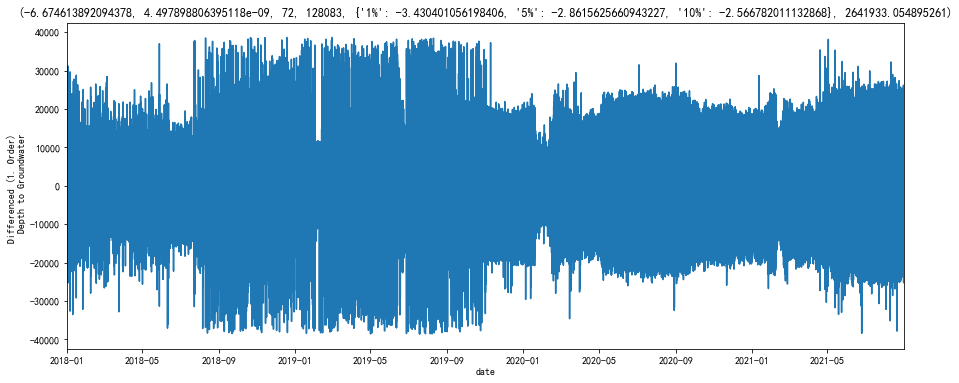

In [96]:
df = df.fillna(method='ffill',axis=0)  #异常处理

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['总有功功率（kw）_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax=ax)

In [103]:
df['总有功功率（kw）'] = df['总有功功率（kw）'].astype(float)
df['最高温度'] = df['最高温度'].astype(float)
df['最低温度'] = df['最低温度'].astype(float)
df['白天风力风向'] = df['白天风力风向'].astype(float)
df['夜晚风力风向'] = df['夜晚风力风向'].astype(float)
df['天气1'] = df['天气1'].astype(float)
df['天气2'] = df['天气2'].astype(float)
df['总有功功率（kw）_diff_1'] = df['总有功功率（kw）_diff_1'].astype(float)
#df['总有功功率（kw）_log'] = df['总有功功率（kw）_log'].astype(float)

## 7 特征工程

## 7.3 时间序列分解

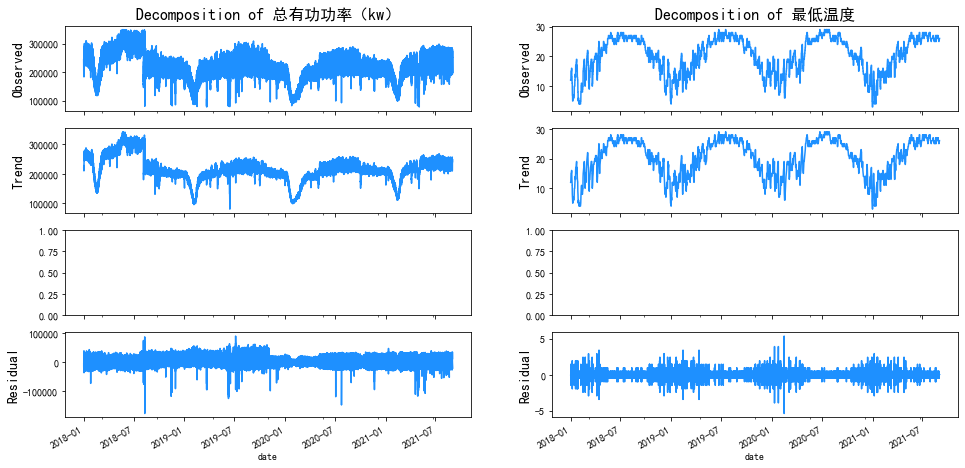

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    '总有功功率（kw）']

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend=0)  #使用滑动平均的方法进行时间序列分解
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['总有功功率（kw）', '最低温度']):

    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend=0)

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')  #趋势非线性线
    ax[1,i].set_ylabel('Trend', fontsize=14)

    #res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')  #季节周期
    #ax[2,i].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')  #残差网络分析
    ax[3,i].set_ylabel('Residual', fontsize=14)



plt.show()

## 7.7 相关性分析

Text(0.5, 1.0, 'Correlation Matrix of Lagged Features')

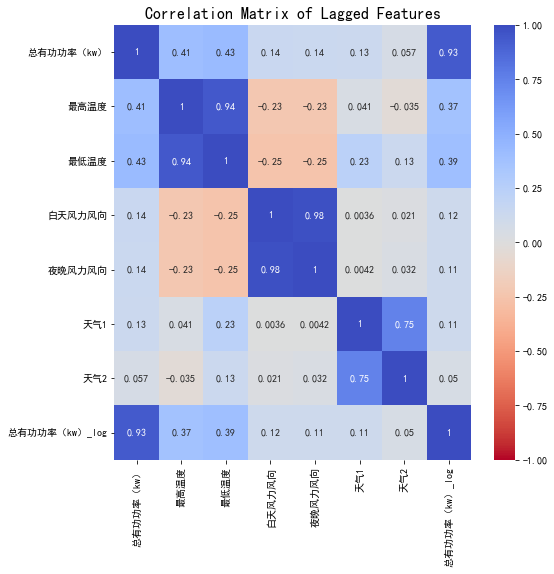

In [105]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

shifted_cols = df.columns[:9]
corrmat = df[shifted_cols].corr()  #输出函数的相关性

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')  #画出相关性的热力图
ax.set_title('Correlation Matrix of Lagged Features', fontsize=16)

## 7.8 自相关分析

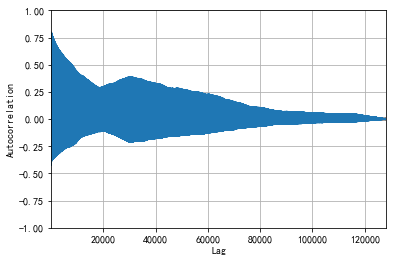

In [106]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['总有功功率（kw）_diff_1'])  #自相关图
plt.show()

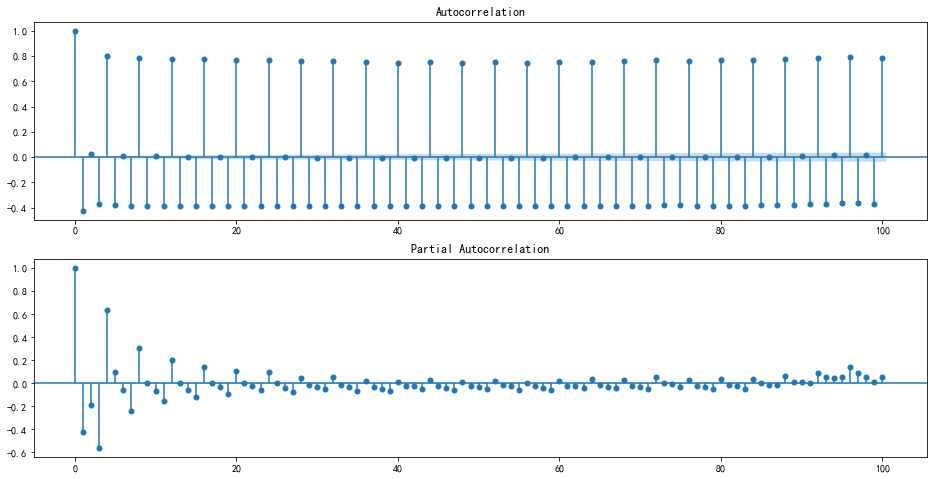

In [107]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['总有功功率（kw）_diff_1'], lags=100, ax=ax[0])  #自相关图
plot_pacf(df['总有功功率（kw）_diff_1'], lags=100, ax=ax[1])  #偏自相关图

plt.show()

## 8建模

## 8.1 时序中交叉验证

- 由于存在时间先后的问题，对于存在时间特性的分类或者回归问题不能简单的使用StratifiekdKFold或者KFold进行交叉验证，更不能shuffle，会带来一定的时序特征交叉的问题，比如用未来的数据来预测过去的数据，这样的交叉验证结果在业务上意义不大，在比赛中也很容易造成过拟合的问题。简单总结一下时间序列的交叉验证方法：

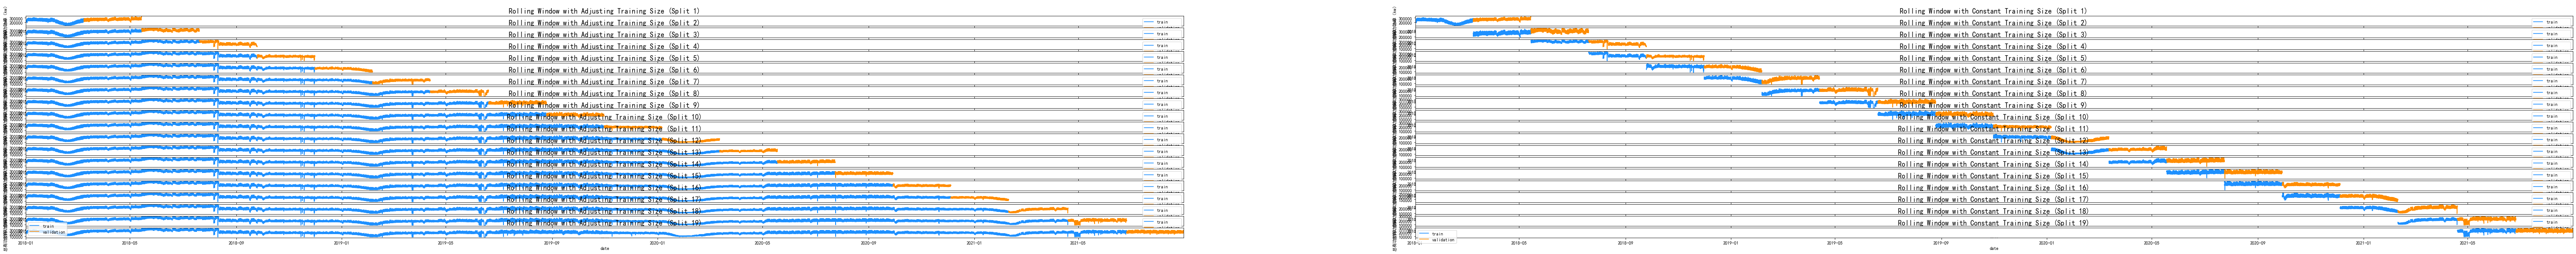

In [109]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 19  #训练量为3

X = df['date']
y = df['总有功功率（kw）']

folds = TimeSeriesSplit(n_splits=N_SPLITS)
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(101, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):  #获取训练数据和测试数据
    X_train, X_valid = X[train_index], X[valid_index]  #获取x的训练，测试数据
    y_train, y_valid = y[train_index], y[valid_index]  #获取y的训练，测试数据

    sns.lineplot(  #输出训练数据
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):  #输出测试数据
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):  #x轴的范围
    ax[i, 0].set_xlim([date(2018, 1, 1), date(2021, 8, 31)])
    ax[i, 1].set_xlim([date(2018, 1, 1), date(2021, 8, 31)])

plt.tight_layout()
plt.show()

## 8.2 单变量时间序列模型

In [110]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
df = df.fillna(0)
univariate_df = df[['date', '总有功功率（kw）']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

102524 25632


## 8.2.1ARIMA 10天预测

In [44]:
# from datetime import datetime   #数据索引改为时间
# import statsmodels.api as sm     #acf,pacf图
# from statsmodels.tsa.stattools import adfuller  #adf检验
# from pandas.plotting import autocorrelation_plot
# from statsmodels.tsa.arima_model import ARIMA

In [134]:
test_size = 96*10 # 96
# 将数据分为训练集、测试集
train_size = len(df) - test_size  #预测训练值范围
train = df['总有功功率（kw）'][:train_size]
test = df['总有功功率（kw）'][-test_size:]
trate = df['总有功功率（kw）']
ts = df['总有功功率（kw）']
ts

date
2018-01-01 00:00:00    244033.7682
2018-01-01 00:15:00    232720.6402
2018-01-01 00:30:00    231685.6891
2018-01-01 00:45:00    227581.3317
2018-01-01 01:00:00    233482.4269
                          ...     
2021-08-31 22:45:00    202409.1270
2021-08-31 23:00:00    218576.4635
2021-08-31 23:15:00    200112.5091
2021-08-31 23:30:00    199865.5937
2021-08-31 23:45:00    198483.5592
Name: 总有功功率（kw）, Length: 128156, dtype: float64

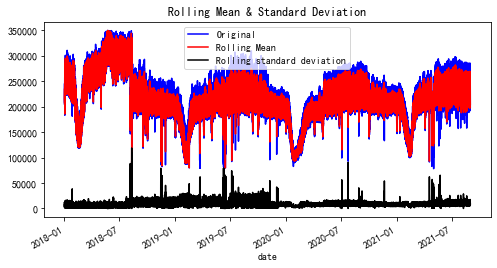

In [135]:
# 移动平均图
def draw_trend(timeseries, size):
    f = plt.figure(facecolor='white',figsize=(8,4))
    # 对size个数据进行移动平均
    rol_mean = timeseries.rolling(window=size).mean()
    # 对size个数据移动平均的方差
    rol_std = timeseries.rolling(window=size).std()
 
    timeseries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_std.plot(color='black', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
def draw_ts(timeseries):
    f = plt.figure(facecolor='white')
    timeseries.plot(color='blue')
    plt.show()
    
#Dickey-Fuller test:
def teststationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 查看原始数据的均值和方差
draw_trend(ts,4)


In [136]:
# Dickey-Fuller的结果
teststationarity(ts)

Test Statistic                -6.149084e+00
p-value                        7.639648e-08
#Lags Used                     7.200000e+01
Number of Observations Used    1.280830e+05
Critical Value (1%)           -3.430401e+00
Critical Value (5%)           -2.861563e+00
Critical Value (10%)          -2.566782e+00
dtype: float64

In [137]:
ts_log = np.log(ts)

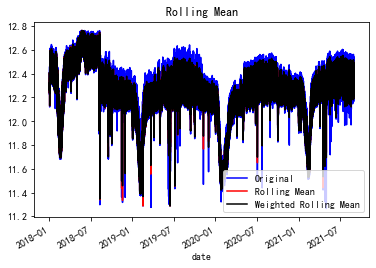

In [138]:
def draw_moving(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.DataFrame.ewm(timeSeries, span=size).mean()
    #rol_weighted_mean=timeSeries.ewm(halflife=size,min_periods=0,adjust=True,ignore_na=False).mean()
 
    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()
draw_moving(ts_log,4)


In [139]:
diff_4 = ts_log.diff(4)
diff_4.dropna(inplace=True)
diff_4_1 = diff_4.diff(1)
diff_4_1.dropna(inplace=True)
teststationarity(diff_4_1)

Test Statistic                    -82.209633
p-value                             0.000000
#Lags Used                         72.000000
Number of Observations Used    128078.000000
Critical Value (1%)                -3.430401
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64

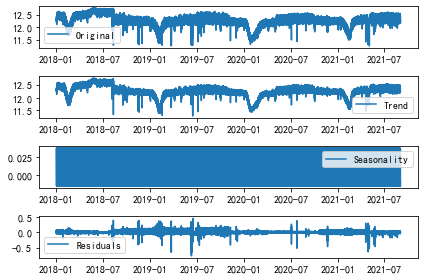

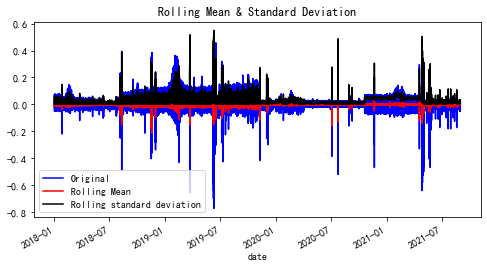

Test Statistic                    -80.178092
p-value                             0.000000
#Lags Used                         72.000000
Number of Observations Used    128079.000000
Critical Value (1%)                -3.430401
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64

In [140]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(timeseries):
    
    # 返回包含三个部分 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)
    decomposition = seasonal_decompose(timeseries,model='addictive',period=4)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return trend , seasonal, residual
trend , seasonal, residual = decompose(ts_log)
residual.dropna(inplace=True)
draw_trend(residual,4)
teststationarity(residual)


In [141]:
rol_mean = ts_log.rolling(window=4).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
teststationarity(ts_diff_1)

Test Statistic                    -91.317928
p-value                             0.000000
#Lags Used                         71.000000
Number of Observations Used    128080.000000
Critical Value (1%)                -3.430401
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64

In [142]:
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)
teststationarity(ts_diff_2)

Test Statistic                    -82.209633
p-value                             0.000000
#Lags Used                         72.000000
Number of Observations Used    128078.000000
Critical Value (1%)                -3.430401
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64

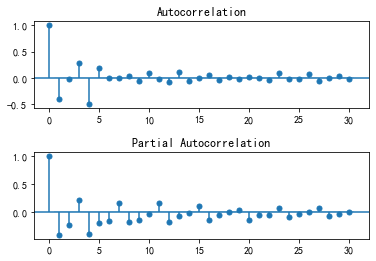

In [143]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def draw_acf_pacf(ts,lags):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts,ax=ax1,lags=lags)
    ax2 = f.add_subplot(212)
    plot_pacf(ts,ax=ax2,lags=lags)
    plt.subplots_adjust(hspace=0.5)
    plt.show()
draw_acf_pacf(ts_diff_2,30)

In [57]:
#自动定阶
# warnings.filterwarnings("ignore")
# from pandas.plotting import autocorrelation_plot
# from pmdarima.arima import auto_arima
# model=auto_arima(train,trace=True,error_action="ignore",suppress_warnings=True)
# model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=23.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=589805.507, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=583470.698, Time=1.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=579613.366, Time=1.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=589803.507, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=579802.103, Time=2.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=576933.265, Time=9.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=18.93 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=577591.137, Time=4.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=570366.131, Time=13.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=569312.930, Time=15.83 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=540464.588, Time=29.51 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=548031.814, Time=26.16 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=539330.849, Time=42.10 sec
 ARIMA(4,1,2

ARIMA(order=(5, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [144]:
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(endog=ts_diff_1[:-test_size], order=(4,1,5),exog=df['最高温度'][4:-test_size],) 
result_arima = model.fit()

In [145]:
# predict_ts = result_arima.predict('2021-08-20 00:00:00', '2021-08-25 23:45:00',dynamic=True, typ='levels')
# predict_ts = result_arima.predict()
predict_ts=result_arima.predict(0,len(df)-5,exog = ts_diff_1[-test_size:]) # 放入预测数据
# forecas = result_arima.forecast(960,exog = test)                      # 预测未来数据
predict_ts.index = df[4:].index
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
# 移动平均还原
rol_sum = ts_log.rolling(window=3).sum()
rol_recover = diff_recover*4 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)


In [146]:
ts = ts[log_recover.index]  # 过滤没有预测的记录plt.figure(facecolor='white')
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100
rmse_score = math.sqrt(mse(log_recover,ts))
mae_score = mae(log_recover,ts)
mape_score = mape(log_recover,ts)
#计算指定置信水平下的预测准确率
#level为小数
def comput_acc(real,predict,level):
    num_error=0
    for i in range(len(real)):
        if abs(real[i]-predict[i])/real[i]>level:
            num_error+=1
    return 1-num_error/len(real)
acc = comput_acc(ts,log_recover,0.2)

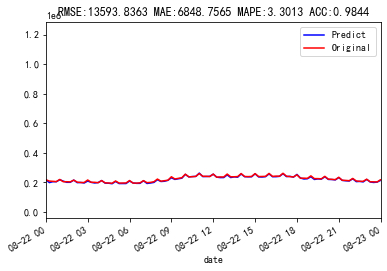

In [150]:
log_recover.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.xlim('2021-08-22', '2021-08-23')
plt.legend(loc='best')
plt.title(f'RMSE:{rmse_score:.4f} MAE:{mae_score:.4f} MAPE:{mape_score:.4f} ACC:{acc:.4f}')
plt.show()

# LSTM
## LSTM十天预测

In [111]:
test_size = 96*10  #预测测试值范围
train_size = len(df) - test_size  #预测训练值范围
df = df.fillna(0)
univariate_df = df[['date', '总有功功率（kw）']].copy()
univariate_df.columns = ['ds', 'y']


# LSTM对输入数据的大小敏感，需要对输入数据做标准化处理
# 使用MinMaxScaler将数据映射到0-1区间
from sklearn.preprocessing import MinMaxScaler
data = univariate_df.filter(['y'])
dataset = data.values
scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

#添加预测区间10天
# import datetime
# indexs = pd.date_range(start='2021-09-01 00:00:00',end='2021-09-10 23:45:00',freq='15T')
# indexs = DataFrame(indexs,columns=['ds'])
# univariate_df = DataFrame(univariate_df) 
# univariate_df = pd.concat((univariate_df,indexs),axis=0,join='outer')
# univariate_df.index = univariate_df['ds']

scaled_data[-10:]

array([[-0.51241047],
       [-0.5192516 ],
       [-0.46299191],
       [-0.53187307],
       [-0.53937357],
       [-0.54199494],
       [-0.48243437],
       [-0.55045569],
       [-0.55136533],
       [-0.55645675]])

In [112]:
def check(du):
    #正态检测
    u = du.mean()
    # 计算标准差
    std = du.std()
    # 计算P值
    res=kstest(du.astype(float),  'norm', (u, std))[1]
    print(res)
    # 判断p值是否服从正态分布，p<=0.05 则服从正态分布，否则不服从。
    if res<=0.05:
        print('该列数据服从正态分布------------')
        print('均值为：%.3f，标准差为：%.3f' % (u, std))
        print('------------------------------')
    else:
        print("错误")

def sta(sta_du):
    stas = []
    u = sta_du.mean()
    std = sta_du.std()
    for i in sta_du:
        stas.append((i-u)/(std*std))
    return stas

In [113]:
# du_day_max = df['最高温度'].resample('D').mean()
# du_day_min = df['最低温度'].resample('D').mean()
du_day_max = df['最高温度']
du_day_min = df['最低温度']

#温度标准化
from scipy.stats import kstest
check(du_day_max)
check(du_day_min)
du_day_max = sta(du_day_max)
du_day_min = sta(du_day_min)

0.0
该列数据服从正态分布------------
均值为：27.610，标准差为：6.300
------------------------------
0.0
该列数据服从正态分布------------
均值为：20.315，标准差为：6.128
------------------------------


<AxesSubplot:ylabel='Density'>

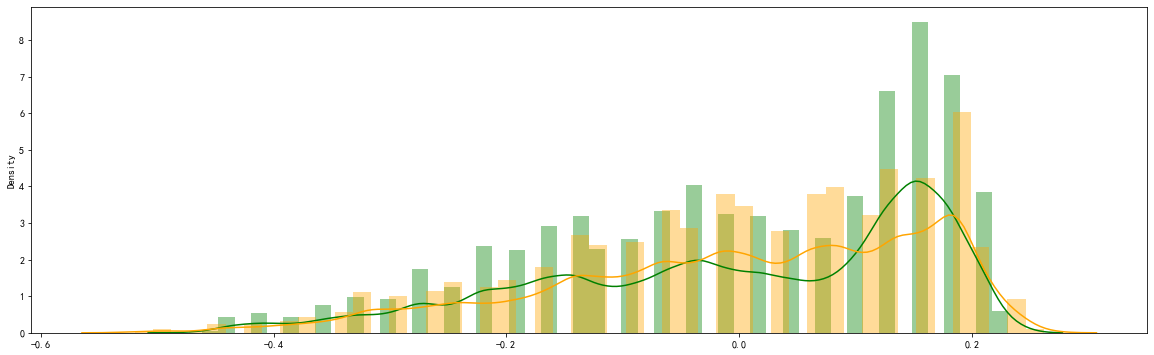

In [114]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
sns.distplot(du_day_min, ax=ax,color='green',label='du_day_max') #直方图和核密度图的结合，查看单个连续型变量的分布
sns.distplot(du_day_max, ax=ax, color='orange',label='du_day_min') #直方图和核密度图的结合，查看单个连续型变量的分布

In [115]:
# day_index = pd.date_range(start='2018-01-01',end='2021-08-31',freq='D')
# du_day_max = pd.DataFrame(du_day_max,columns=['max'])
# du_day_min = pd.DataFrame(du_day_min,columns=['min'])
# day_index = pd.DataFrame(day_index,columns=['date'])
# du_day_max = pd.concat((du_day_max,day_index),axis=1)
# du_day_min = pd.concat((du_day_min,day_index),axis=1)
# du_day_max.index = du_day_max['date']
# du_day_min.index = du_day_min['date']
du_day_max = list(map(list, zip(du_day_max)))
du_day_min = list(map(list, zip(du_day_min)))

In [116]:
look_back = int(24*60/15) # 96
# 将数据分为训练集、测试集
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

# 生成t-x数据
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 设置随机种子，保证复现

np.random.seed(7)


x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

#添加特征列
x_train = np.append(x_train,du_day_max[0:train_size-look_back*2],axis=1)
x_train = np.append(x_train,du_day_min[0:train_size-look_back*2],axis=1)
x_test = np.append(x_test,du_day_max[train_size:],axis=1)
x_test = np.append(x_test,du_day_min[train_size:],axis=1)


# LSTM网络的输入为【批次大小(行数)，时间步长，特征数量(列数)】
# 将数据转换为符合输入的格式
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

127004 960


In [117]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 创建LSTM模型，拟合数据
model = Sequential()

# 添加128个LSTM神经元的隐层网络
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]))) #return_sequences=True
#model.add(LSTM(64, return_sequences=False))
model.add(Dense(30))
#model.add(Dense(1))

# 损失函数与adam优化器
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练数据10期, batch_size:一次训练抓取的样本数量
model.fit(x_train, y_train, batch_size=16, epochs=10 )  #validation_data=(x_test, y_test)

model.summary()

Epoch 1/10
7938/7938 [==============================] - 32s 4ms/step - loss: 0.0011
Epoch 2/10
7938/7938 [==============================] - 31s 4ms/step - loss: 6.3817e-04
Epoch 3/10
7938/7938 [==============================] - 31s 4ms/step - loss: 6.1336e-04
Epoch 4/10
7938/7938 [==============================] - 29s 4ms/step - loss: 5.9348e-04
Epoch 5/10
7938/7938 [==============================] - 30s 4ms/step - loss: 5.8351e-04
Epoch 6/10
7938/7938 [==============================] - 25s 3ms/step - loss: 5.7474e-04
Epoch 7/10
7938/7938 [==============================] - 30s 4ms/step - loss: 5.6756e-04
Epoch 8/10
7938/7938 [==============================] - 30s 4ms/step - loss: 5.6054e-04
Epoch 9/10
7938/7938 [==============================] - 31s 4ms/step - loss: 5.5244e-04
Epoch 10/10
7938/7938 [==============================] - 31s 4ms/step - loss: 5.4905e-04
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output S

In [49]:
# for i in range(test_predict[0,:].size):
#     sums = test_predict[i,:].mean()
#     test_predict[i,0] = sums

In [118]:
# 预测
#train_predict = model.predict(x_train)
test_predict = model.predict(x_test) # 3个月的数据

# 前面把数据缩放到0-1范围。
# 现在跟实际值做比较，将预测值反标准化，从0-1范围转换为原数据范围
#train_predict = scaler.inverse_transform(train_predict)
#y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# 评估RMSE误差
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,1]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,1])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
from sklearn.metrics import r2_score
print('R2-score:',r2_score(y_test[0], test_predict[:,1]))
#print('R2-score:',r2_score(y_test[0][:-96*10], test_predict[:-96*10,0]))

RMSE: 3292.317232065485
R2-score: 0.982798861698612


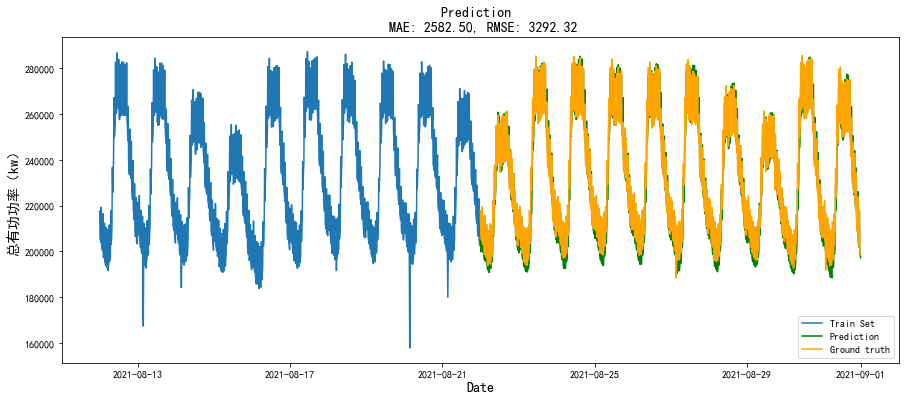

In [119]:
# 准备画图 - 训练数据
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_predict[:,0].size)['ds']

# 准备画图 - 测试数据
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks[-96*10:], y=y_train[-96*10:], ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='总有功功率（kw）', fontsize=14)
plt.show()

<AxesSubplot:xlabel='ds'>

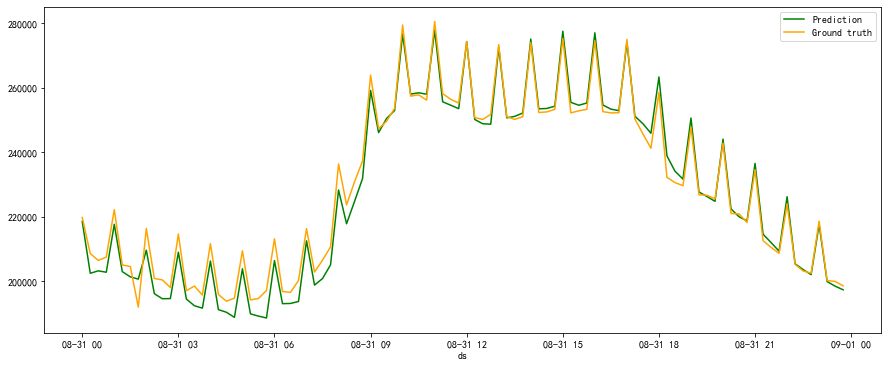

In [120]:
# 准备画图 - 测试数据
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_test_ticks[-96*1:], y=test_predict[:,0][-96*1:], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks[-96*1:], y=y_test[0][-96*1:], ax=ax, color='orange', label='Ground truth') #navajowhite

## LSTM三十天预测

In [121]:
df_day = df['总有功功率（kw）'].resample('1H').sum()
df_day = pd.DataFrame(df_day)
day_index = pd.date_range(start='2018-01-01 00:00:00',end='2021-08-31 23:00:00',freq='1H')
day_index = pd.DataFrame(day_index,columns=['date_day'])
day_index.index = day_index['date_day']
df_day = pd.concat((df_day,day_index),axis=1)

In [122]:
test_size =  90*24 #预测测试值范围
train_size = len(df_day) - test_size  #预测训练值范围

df_day = df_day.fillna(0)
univariate_df = df_day.copy()
univariate_df.columns = ['y', 'ds']


# LSTM对输入数据的大小敏感，需要对输入数据做标准化处理
# 使用MinMaxScaler将数据映射到0-1区间
from sklearn.preprocessing import MinMaxScaler
data = univariate_df.filter(['y'])
dataset = data.values
scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)
scaled_data[-10:]

array([[-0.26174252],
       [-0.26068638],
       [-0.26213896],
       [-0.27601169],
       [-0.31984333],
       [-0.33721524],
       [-0.35426664],
       [-0.38048445],
       [-0.40304453],
       [-0.41556412]])

In [123]:
def check(du):
    #正态检测
    u = du.mean()
    # 计算标准差
    std = du.std()
    # 计算P值
    res=kstest(du.astype(float),  'norm', (u, std))[1]
    print(res)
    # 判断p值是否服从正态分布，p<=0.05 则服从正态分布，否则不服从。
    if res<=0.05:
        print('该列数据服从正态分布------------')
        print('均值为：%.3f，标准差为：%.3f' % (u, std))
        print('------------------------------')
    else:
        print("错误")

def sta(sta_du):
    stas = []
    u = sta_du.mean()
    std = sta_du.std()
    for i in sta_du:
        stas.append((i-u)/(std*std))
    return stas

In [124]:
du_day_max = df['最高温度'].resample('1H').mean()
du_day_min = df['最低温度'].resample('1H').mean()
du_day_max = du_day_max.fillna(method='ffill',axis=0)  #异常处理
du_day_min = du_day_min.fillna(method='ffill',axis=0)  #异常处理

#温度标准化
from scipy.stats import kstest
check(du_day_max)
check(du_day_min)
du_day_max = sta(du_day_max)
du_day_min = sta(du_day_min)

2.810837981165089e-287
该列数据服从正态分布------------
均值为：27.610，标准差为：6.294
------------------------------
0.0
该列数据服从正态分布------------
均值为：20.313，标准差为：6.121
------------------------------


<AxesSubplot:ylabel='Density'>

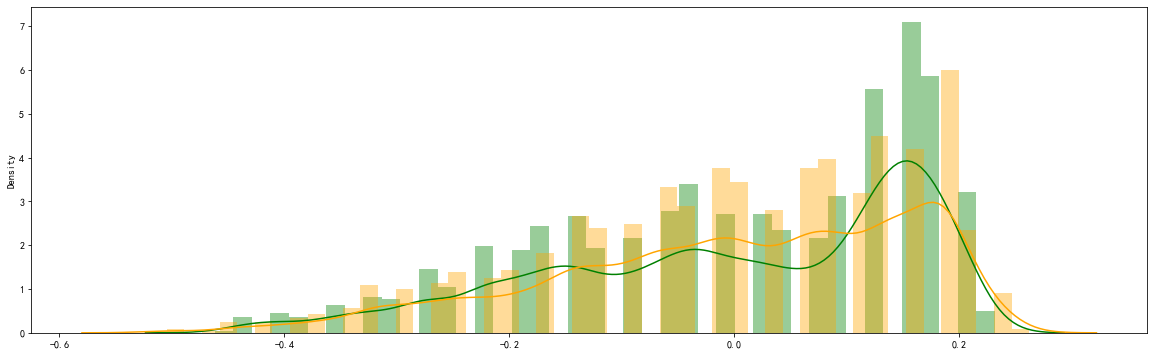

In [125]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
sns.distplot(du_day_min, ax=ax,color='green',label='du_day_max') #直方图和核密度图的结合，查看单个连续型变量的分布
sns.distplot(du_day_max, ax=ax, color='orange',label='du_day_min') #直方图和核密度图的结合，查看单个连续型变量的分布

In [126]:
# day_index = pd.date_range(start='2018-01-01',end='2021-08-31',freq='D')
# du_day_max = pd.DataFrame(du_day_max,columns=['max'])
# du_day_min = pd.DataFrame(du_day_min,columns=['min'])
# day_index = pd.DataFrame(day_index,columns=['date'])
# du_day_max = pd.concat((du_day_max,day_index),axis=1)
# du_day_min = pd.concat((du_day_min,day_index),axis=1)
# du_day_max.index = du_day_max['date']
# du_day_min.index = du_day_min['date']
du_day_max = list(map(list, zip(du_day_max)))
du_day_min = list(map(list, zip(du_day_min)))

In [127]:
look_back = 24 # 7
# 将数据分为训练集、测试集
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

# 生成t-x数据
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 设置随机种子，保证复现

np.random.seed(7)


x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

#添加特征列
x_train = np.append(x_train,du_day_max[0:train_size-look_back*2],axis=1)
x_train = np.append(x_train,du_day_min[0:train_size-look_back*2],axis=1)
x_test = np.append(x_test,du_day_max[train_size:],axis=1)
x_test = np.append(x_test,du_day_min[train_size:],axis=1)

# LSTM网络的输入为【批次大小(行数)，时间步长，特征数量(列数)】
# 将数据转换为符合输入的格式
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

29928 2160


In [128]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 创建LSTM模型，拟合数据
model = Sequential()

# 添加128个LSTM神经元的隐层网络
model.add(LSTM(384, input_shape=(x_train.shape[1], x_train.shape[2]))) #return_sequences=True
#model.add(LSTM(64, return_sequences=False))
model.add(Dense(30))
#model.add(Dense(1))

# 损失函数与adam优化器
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练数据10期, batch_size:一次训练抓取的样本数量
model.fit(x_train, y_train, batch_size=16, epochs=10 )  #validation_data=(x_test, y_test)

model.summary()

Epoch 1/10
1871/1871 [==============================] - 13s 5ms/step - loss: 0.0019
Epoch 2/10
1871/1871 [==============================] - 9s 5ms/step - loss: 5.9456e-04
Epoch 3/10
1871/1871 [==============================] - 7s 4ms/step - loss: 5.3597e-04
Epoch 4/10
1871/1871 [==============================] - 8s 4ms/step - loss: 4.9165e-04
Epoch 5/10
1871/1871 [==============================] - 9s 5ms/step - loss: 4.8203e-04
Epoch 6/10
1871/1871 [==============================] - 7s 4ms/step - loss: 4.7234e-04
Epoch 7/10
1871/1871 [==============================] - 7s 4ms/step - loss: 4.5789e-04
Epoch 8/10
1871/1871 [==============================] - 8s 4ms/step - loss: 4.7579e-04
Epoch 9/10
1871/1871 [==============================] - 9s 5ms/step - loss: 4.4849e-04
Epoch 10/10
1871/1871 [==============================] - 9s 5ms/step - loss: 4.4760e-04
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape   

In [129]:
# 预测
# train_predict = model.predict(x_train)
test_predict = model.predict(x_test) # 3个月的数据

# 前面把数据缩放到0-1范围。
# 现在跟实际值做比较，将预测值反标准化，从0-1范围转换为原数据范围
# train_predict = scaler.inverse_transform(train_predict)
# y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# 评估RMSE误差
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
from sklearn.metrics import r2_score
print('R2-score:',r2_score(y_test[0], test_predict[:,1]))
#print('R2-score:',r2_score(y_test[0][:-96*10], test_predict[:-96*10,0]))

RMSE: 28996.343162613444
R2-score: 0.920799724697506


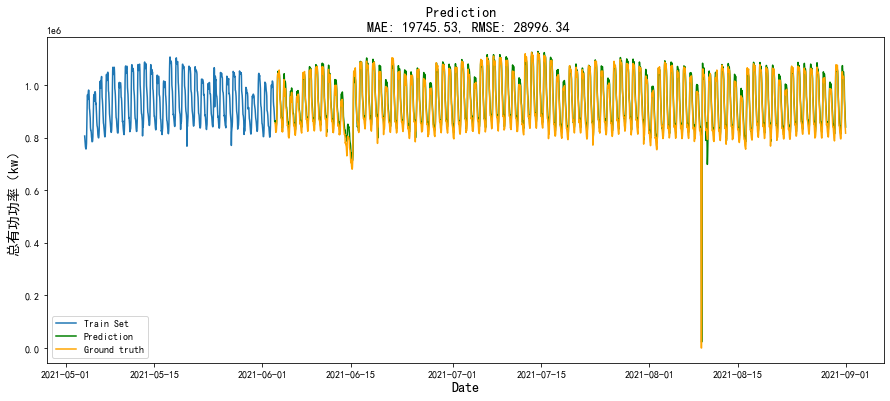

In [130]:
# 准备画图 - 训练数据
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_predict[:,0].size)['ds']

# 准备画图 - 测试数据
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks[-30*24:],y=y_train[-30*24:],ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite
#sns.lineplot(x=x_train_ticks, y=train_predict[:,0], ax=ax, color='red', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='总有功功率（kw）', fontsize=14)
plt.show()

- 对一天求和，并且求出其最大最小值

In [131]:
day_sum = []
day_index = pd.date_range(start='2021-06-03',end='2021-08-31',freq='D')
day_index = pd.DataFrame(day_index,columns=['date_day'])

for i in range(90):
#     print(test_predict[i*24:(i+1)*24-1,:].sum())
    day_sum.append(test_predict[i*24:(i+1)*24-1,:].sum())
# sum_max = day_sum.find(day_sum.max())
day_sum = pd.DataFrame(day_sum,columns=['sum'])
day_sum = pd.concat((day_sum,day_index),axis=1)
day_sum.index = day_sum['date_day']

In [132]:
for i in range(day_sum['sum'].count()):
    if (day_sum.iloc[i,0] == day_sum['sum'].max()):
        print("\n最大值为：",day_sum.iloc[i,0])
        print("最大日期为：",day_sum.iloc[i,1])
    if (day_sum.iloc[i,0] == day_sum['sum'].min()):
        print("\n最小值为：",day_sum.iloc[i,0])
        print("最小日期为：",day_sum.iloc[i,1])
print(f'\nPrediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}')


最小值为： 561742300.0
最小日期为： 2021-06-14 00:00:00

最大值为： 686188900.0
最大日期为： 2021-07-14 00:00:00

Prediction 
 MAE: 19745.53, RMSE: 28996.34
